In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Настройка отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:

def load_data(file_path):
    """Загрузка данных из CSV файла"""
    print("Загрузка данных...")
    df = pd.read_csv(file_path)
    print(f"Загружено {len(df)} строк и {len(df.columns)} столбцов")
    print(f"Столбцы: {list(df.columns)}")
    return df

# Загрузка данных
df = load_data('patients_summary.csv')

Загрузка данных...
Загружено 100 строк и 42 столбцов
Столбцы: ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'MeanAlbumin', 'MeanALP', 'MeanALT', 'MeanAST', 'MeanBilirubin', 'MeanBUN', 'MeanCholesterol', 'MeanCreatinine', 'MeanDiasABP', 'MeanFiO2', 'MeanGCS', 'MeanGlucose', 'MeanHCO3', 'MeanHCT', 'MeanHR', 'MeanK', 'MeanLactate', 'MeanMg', 'MeanMAP', 'MeanMechVent', 'MeanNa', 'MeanNIDiasABP', 'MeanNIMAP', 'MeanNISysABP', 'MeanPaCO2', 'MeanPaO2', 'MeanpH', 'MeanPlatelets', 'MeanRespRate', 'MeanSaO2', 'MeanSysABP', 'MeanTemp', 'MeanTropI', 'MeanTropT', 'MeanUrine', 'MeanWBC', 'MeanWeight']


#### 2.1. Устранение дубликатов, пустых записей
Из исходных данных необходимо убрать пустые и дублирующие записи.

In [4]:
# Удаление дубликатов и полностью пустых строк

def remove_duplicates_and_empty(df):
    
    # Проверка дубликатов
    duplicates = df.duplicated().sum()
    print(f"Найдено дубликатов: {duplicates}")
    
    if duplicates > 0:
        df = df.drop_duplicates()
        print(f"Удалено {duplicates} дубликатов")
    
    # Проверка полностью пустых строк
    empty_rows = df.isnull().all(axis=1).sum()
    print(f"Найдено полностью пустых строк: {empty_rows}")
    
    if empty_rows > 0:
        df = df.dropna(how='all')
        print(f"Удалено {empty_rows} полностью пустых строк")
    
    print(f"Осталось строк: {len(df)}")
    return df

df = remove_duplicates_and_empty(df)

Найдено дубликатов: 0
Найдено полностью пустых строк: 0
Осталось строк: 100


#### 2.2. Обработка пропущенных значений, выбросов
Необходимо проанализировать количество пропущенных значений и выполнить их обработку, проанализировать значения, которыми заполнены признаки и обработать их при необходимости (выбросы, категориальные признаки и т.п.). Визуализируйте результат.

Топ-10 столбцов с наибольшим количеством пропусков:
                 Пропущено  Процент
MeanTropT              100    100.0
MeanTropI              100    100.0
MeanCholesterol         93     93.0
MeanRespRate            67     67.0
MeanAlbumin             59     59.0
MeanSaO2                57     57.0
MeanALT                 57     57.0
MeanALP                 56     56.0
MeanAST                 56     56.0
MeanBilirubin           55     55.0


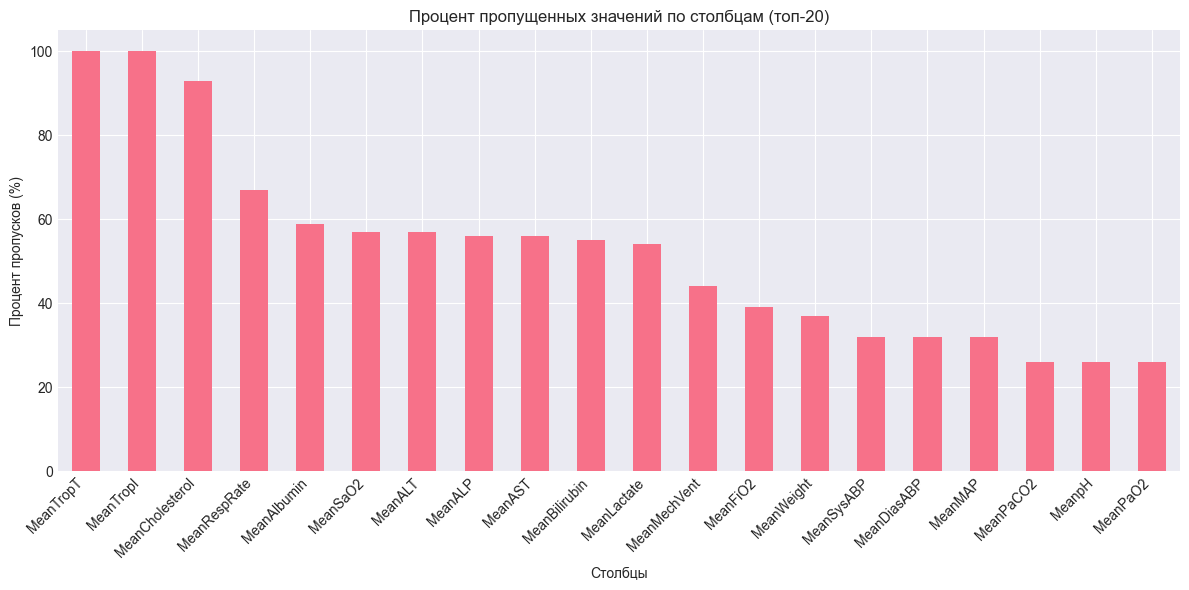

In [5]:
# Анализ пропущенных значений

def analyze_missing_values(df):
    
    # Анализ пропущенных значений
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Пропущено': missing,
        'Процент': missing_percent
    }).sort_values('Процент', ascending=False)
    
    print("Топ-10 столбцов с наибольшим количеством пропусков:")
    print(missing_df.head(10))
    
    # Визуализация пропущенных значений
    plt.figure(figsize=(12, 6))
    missing_df['Процент'].head(20).plot(kind='bar')
    plt.title('Процент пропущенных значений по столбцам (топ-20)')
    plt.xlabel('Столбцы')
    plt.ylabel('Процент пропусков (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return missing_df

missing_df = analyze_missing_values(df)

In [6]:
# Обработка пропущенных значений

def handle_missing_values(df, missing_df):
    
    # Создаем копию данных для обработки
    df_processed = df.copy()
    
    # 1. Удаляем столбцы с >80% пропусков
    high_missing_cols = missing_df[missing_df['Процент'] > 80].index.tolist()
    print(f"Удаляем столбцы с >80% пропусков ({len(high_missing_cols)}): {high_missing_cols}")
    df_processed = df_processed.drop(columns=high_missing_cols)
    
    # 2. Для остальных столбцов заполняем медианой (числовые) или модой (категориальные)
    for col in df_processed.columns:
        if df_processed[col].isnull().sum() > 0:
            if df_processed[col].dtype in ['int64', 'float64']:
                # Для числовых - медиана
                median_val = df_processed[col].median()
                df_processed[col] = df_processed[col].fillna(median_val)
            else:
                # Для категориальных - мода
                mode_val = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown'
                df_processed[col] = df_processed[col].fillna(mode_val)
    
    print(f"После обработки пропусков: {df_processed.isnull().sum().sum()} пропусков")
    return df_processed

df_processed = handle_missing_values(df, missing_df)

Удаляем столбцы с >80% пропусков (3): ['MeanTropT', 'MeanTropI', 'MeanCholesterol']
После обработки пропусков: 0 пропусков


In [ ]:
# Обнаружение и обработка выбросов

def detect_and_handle_outliers(df_processed):
        
    # Список числовых столбцов для анализа выбросов
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    
    # Удаляем RecordID из анализа выбросов
    if 'RecordID' in numeric_cols:
        numeric_cols.remove('RecordID')
    
    print(f"Анализируем выбросы в {len(numeric_cols)} числовых столбцах")
    
    # Метод межквартильного размаха (IQR) для обнаружения выбросов
    outliers_info = {}
    
    for col in numeric_cols:
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df_processed[(df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)]
        outliers_count = len(outliers)
        
        if outliers_count > 0:
            outliers_info[col] = {
                'outliers_count': outliers_count,
                'percent': (outliers_count / len(df_processed)) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
    
    # Сортируем по количеству выбросов
    sorted_outliers = sorted(outliers_info.items(), key=lambda x: x[1]['outliers_count'], reverse=True)
    
    print("\nТоп-10 столбцов с наибольшим количеством выбросов:")
    for i, (col, info) in enumerate(sorted_outliers[:10]):
        print(f"{i+1}. {col}: {info['outliers_count']} выбросов ({info['percent']:.1f}%)")
    
    # Визуализация выбросов для нескольких ключевых столбцов
    key_cols = ['Age', 'Height', 'MeanHR', 'MeanTemp', 'MeanWeight']
    key_cols = [col for col in key_cols if col in df_processed.columns]
    
    # fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    # axes = axes.flatten()
    
    # for i, col in enumerate(key_cols[:6]):
    #     if i < len(axes):
    #         df_processed.boxplot(column=col, ax=axes[i])
    #         axes[i].set_title(f'Выбросы: {col}')
    #         axes[i].set_ylabel('Значение')
    
    # plt.tight_layout()
    # plt.show()

    for col in key_cols:
        # Используем px.box для визуализации распределения и выбросов
        fig = px.box(
            df_processed, 
            y=col, 
            title=f'Анализ выбросов: {col}',
            points="all",       # Добавляет точки рядом с ящиком (как в strip plot)
            notched=True,       # Показывает доверительный интервал медианы
            template="plotly_white" # Чистый современный стиль
        )
    
        # Настройка подписей
        fig.update_layout(yaxis_title="Значение")
        fig.show()
    

    # Обработка выбросов - winsorization (ограничение значений)
    print("\nОБРАБОТКА ВЫБРОСОВ (winsorization):")
    df_winsorized = df_processed.copy()
    
    for col in numeric_cols:
        if col in outliers_info:
            lower = outliers_info[col]['lower_bound']
            upper = outliers_info[col]['upper_bound']
            
            # Ограничиваем значения
            df_winsorized[col] = df_winsorized[col].clip(lower=lower, upper=upper)
            print(f"  {col}: ограничено [{lower:.2f}, {upper:.2f}]")
    
    return df_winsorized

In [47]:
df_winsorized = detect_and_handle_outliers(df_processed)

Анализируем выбросы в 38 числовых столбцах

Топ-10 столбцов с наибольшим количеством выбросов:
1. MeanALP: 44 выбросов (44.0%)
2. MeanAST: 44 выбросов (44.0%)
3. MeanLactate: 44 выбросов (44.0%)
4. MeanALT: 42 выбросов (42.0%)
5. MeanBilirubin: 42 выбросов (42.0%)
6. MeanSaO2: 41 выбросов (41.0%)
7. MeanAlbumin: 39 выбросов (39.0%)
8. MeanRespRate: 32 выбросов (32.0%)
9. MeanFiO2: 20 выбросов (20.0%)
10. MeanWeight: 20 выбросов (20.0%)



ОБРАБОТКА ВЫБРОСОВ (winsorization):
  MeanAlbumin: ограничено [2.90, 2.90]
  MeanALP: ограничено [72.00, 72.00]
  MeanALT: ограничено [23.00, 23.00]
  MeanAST: ограничено [39.50, 39.50]
  MeanBilirubin: ограничено [0.50, 0.50]
  MeanBUN: ограничено [-13.88, 57.62]
  MeanCreatinine: ограничено [-0.22, 2.23]
  MeanDiasABP: ограничено [45.36, 72.19]
  MeanFiO2: ограничено [0.42, 0.66]
  MeanGlucose: ограничено [48.31, 221.15]
  MeanHCO3: ограничено [15.69, 32.19]
  MeanHCT: ограничено [21.36, 40.41]
  MeanHR: ограничено [51.15, 112.83]
  MeanK: ограничено [3.12, 5.09]
  MeanLactate: ограничено [1.80, 1.80]
  MeanMg: ограничено [1.32, 2.73]
  MeanMAP: ограничено [60.29, 98.51]
  MeanNa: ограничено [129.66, 147.91]
  MeanNISysABP: ограничено [76.48, 152.09]
  MeanPaCO2: ограничено [30.76, 47.19]
  MeanPaO2: ограничено [59.90, 206.04]
  MeanpH: ограничено [7.30, 7.49]
  MeanPlatelets: ограничено [-43.61, 426.41]
  MeanRespRate: ограничено [19.17, 19.17]
  MeanSaO2: ограничено [97.33, 97.33]

#### 2.3. Обработка аномалий (аномальные объекты)
Необходимо проверить данные на наличие аномальных объектов, провести анализ и обработку аномалий.

In [9]:

def detect_anomalous_objects(df_winsorized):
    """Обнаружение аномальных объектов"""
    
    # print(df_winsorized[df_winsorized['Height'] < 0])
    # 1. Проверка отрицательных значений в Height
    print("1. Проверка отрицательных значений роста (Height):")
    negative_height = df_winsorized[df_winsorized['Height'] < 0]
    print(f"   Найдено {len(negative_height)} записей с отрицательным ростом")
    
    if len(negative_height) > 0:
        print("   Примеры записей с отрицательным ростом:")
        print(negative_height[['RecordID', 'Age', 'Height']].head())
    
    # 2. Проверка нереалистичных значений возраста
    print("\n2. Проверка возраста (Age):")
    unrealistic_age = df_winsorized[(df_winsorized['Age'] < 0) | (df_winsorized['Age'] > 120)]
    print(f"   Найдено {len(unrealistic_age)} записей с нереалистичным возрастом")
    
    # 3. Проверка нереалистичных значений температуры
    print("\n3. Проверка температуры (MeanTemp):")
    if 'MeanTemp' in df_winsorized.columns:
        unrealistic_temp = df_winsorized[(df_winsorized['MeanTemp'] < 30) | (df_winsorized['MeanTemp'] > 45)]
        print(f"   Найдено {len(unrealistic_temp)} записей с нереалистичной температурой")
    
    # 4. Использование метода локального выброса (LOF) для обнаружения многомерных аномалий
    print("\n4. Обнаружение многомерных аномалий:")
    
    # Выбираем ключевые числовые признаки для анализа
    key_features = ['Age', 'Height', 'MeanHR', 'MeanTemp', 'MeanWeight']
    key_features = [col for col in key_features if col in df_winsorized.columns]
    print(f"    Коллекция признаков для анализа {key_features}")

    if len(key_features) >= 3:
        from sklearn.neighbors import LocalOutlierFactor
        
        # Нормализуем данные
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df_winsorized[key_features].fillna(0))
        
        # Применяем LOF
        lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
        outliers = lof.fit_predict(X_scaled)
        
        # Помечаем аномалии
        df_winsorized['Is_Anomaly'] = outliers == -1
        anomalies_count = df_winsorized['Is_Anomaly'].sum()
        
        print(f"   Метод LOF обнаружил {anomalies_count} аномальных объектов ({anomalies_count/len(df_winsorized)*100:.1f}%)")
        # Визуализация аномалий
        if len(key_features) >= 2:
            plt.figure(figsize=(10, 6))
            
            # Разделяем на нормальные и аномальные
            normal = df_winsorized[~df_winsorized['Is_Anomaly']]
            anomalous = df_winsorized[df_winsorized['Is_Anomaly']]
            
            plt.scatter(normal[key_features[0]], normal[key_features[1]], 
                       alpha=0.5, label='Нормальные', s=30)
            plt.scatter(anomalous[key_features[0]], anomalous[key_features[1]], 
                       color='red', alpha=0.7, label='Аномальные', s=50, marker='x')
            
            plt.xlabel(key_features[0])
            plt.ylabel(key_features[1])
            plt.title('Обнаружение аномальных объектов')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    return df_winsorized

1. Проверка отрицательных значений роста (Height):
   Найдено 45 записей с отрицательным ростом
   Примеры записей с отрицательным ростом:
    RecordID  Age  Height
0     132539   54    -1.0
2     132541   44    -1.0
4     132545   88    -1.0
8     132554   64    -1.0
10    132556   64    -1.0

2. Проверка возраста (Age):
   Найдено 0 записей с нереалистичным возрастом

3. Проверка температуры (MeanTemp):
   Найдено 0 записей с нереалистичной температурой

4. Обнаружение многомерных аномалий:
    Коллекция признаков для анализа ['Age', 'Height', 'MeanHR', 'MeanTemp', 'MeanWeight']
   Метод LOF обнаружил 10 аномальных объектов (10.0%)


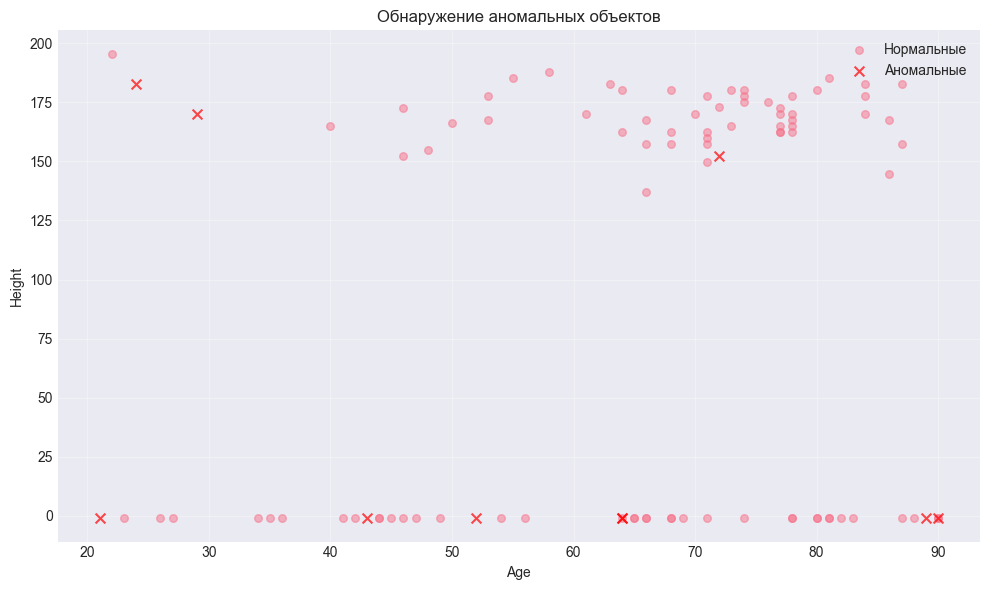

   RecordID  Age  Gender  Height  ICUType  MeanAlbumin  MeanALP  MeanALT  MeanAST  MeanBilirubin    MeanBUN  MeanCreatinine  MeanDiasABP  MeanFiO2    MeanGCS  MeanGlucose   MeanHCO3    MeanHCT     MeanHR  MeanK  MeanLactate    MeanMg    MeanMAP  MeanMechVent      MeanNa  MeanNIDiasABP  MeanNIMAP  MeanNISysABP  MeanPaCO2    MeanPaO2    MeanpH  MeanPlatelets  MeanRespRate   MeanSaO2  MeanSysABP   MeanTemp   MeanUrine    MeanWBC  MeanWeight  Is_Anomaly
0    132539   54       0    -1.0        4          2.9     72.0     23.0     39.5            0.5  10.500000        0.750000    57.865079  0.538462  14.923077   160.000000  27.000000  32.500000  70.810811   4.20          1.8  1.700000  79.766993           1.0  136.500000      50.147059  71.559118    114.382353  38.055556  131.866667  7.398333     203.000000     19.166667  97.333333  115.661111  37.357143  171.052632  10.300000   81.134694       False
1    132540   76       1   175.3        2          2.9     72.0     23.0     39.5           

In [10]:
df_anomaly = detect_anomalous_objects(df_winsorized)

print(df_anomaly.head())

#### 2.4. Получение описательных статистик и графиков распределения всех признаков из итогового набора полей
Необходимо получить различные описательные статистики всех признаков из итогового набора полей. Необходимо построить графики распределения всех признаков из итогового набора полей. Дайте заключение по характеру распределения, сделайте предположение о характере зависимостей между признаками.

In [12]:
 # Удаляем временный столбец аномалий если есть
if 'Is_Anomaly' in df_anomaly.columns:
    df_final = df_anomaly.drop(columns=['Is_Anomaly'])
else:
    df_final = df_anomaly

In [13]:
# 1. Основные описательные статистики
print("1. ОСНОВНЫЕ ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ:")

# Для числовых столбцов
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()

if 'RecordID' in numeric_cols:
    numeric_cols.remove('RecordID')

stats_df = df_final[numeric_cols].describe().T
stats_df = stats_df[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

print("Статистики для ключевых числовых признаков:")
print(stats_df.head(10))

1. ОСНОВНЫЕ ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ:
Статистики для ключевых числовых признаков:
               count       mean           std        min      25%     50%       75%      max
Age            100.0  64.710000  1.798557e+01  21.000000  52.7500   68.50   78.0000   90.000
Gender         100.0   0.450000  5.000000e-01   0.000000   0.0000    0.00    1.0000    1.000
Height         100.0  92.760000  8.565992e+01  -1.000000  -1.0000  153.65  170.2000  195.600
ICUType        100.0   2.740000  9.600084e-01   1.000000   2.0000    3.00    3.0000    4.000
MeanAlbumin    100.0   2.900000  1.785306e-15   2.900000   2.9000    2.90    2.9000    2.900
MeanALP        100.0  72.000000  0.000000e+00  72.000000  72.0000   72.00   72.0000   72.000
MeanALT        100.0  23.000000  0.000000e+00  23.000000  23.0000   23.00   23.0000   23.000
MeanAST        100.0  39.500000  0.000000e+00  39.500000  39.5000   39.50   39.5000   39.500
MeanBilirubin  100.0   0.500000  0.000000e+00   0.500000   0.5000    0.50    0.500

In [49]:
fig_strip = px.strip(df_final[['Age', 'Height']], title='Точечный график распределения')
fig_strip.show()


2. ГРАФИКИ РАСПРЕДЕЛЕНИЯ:


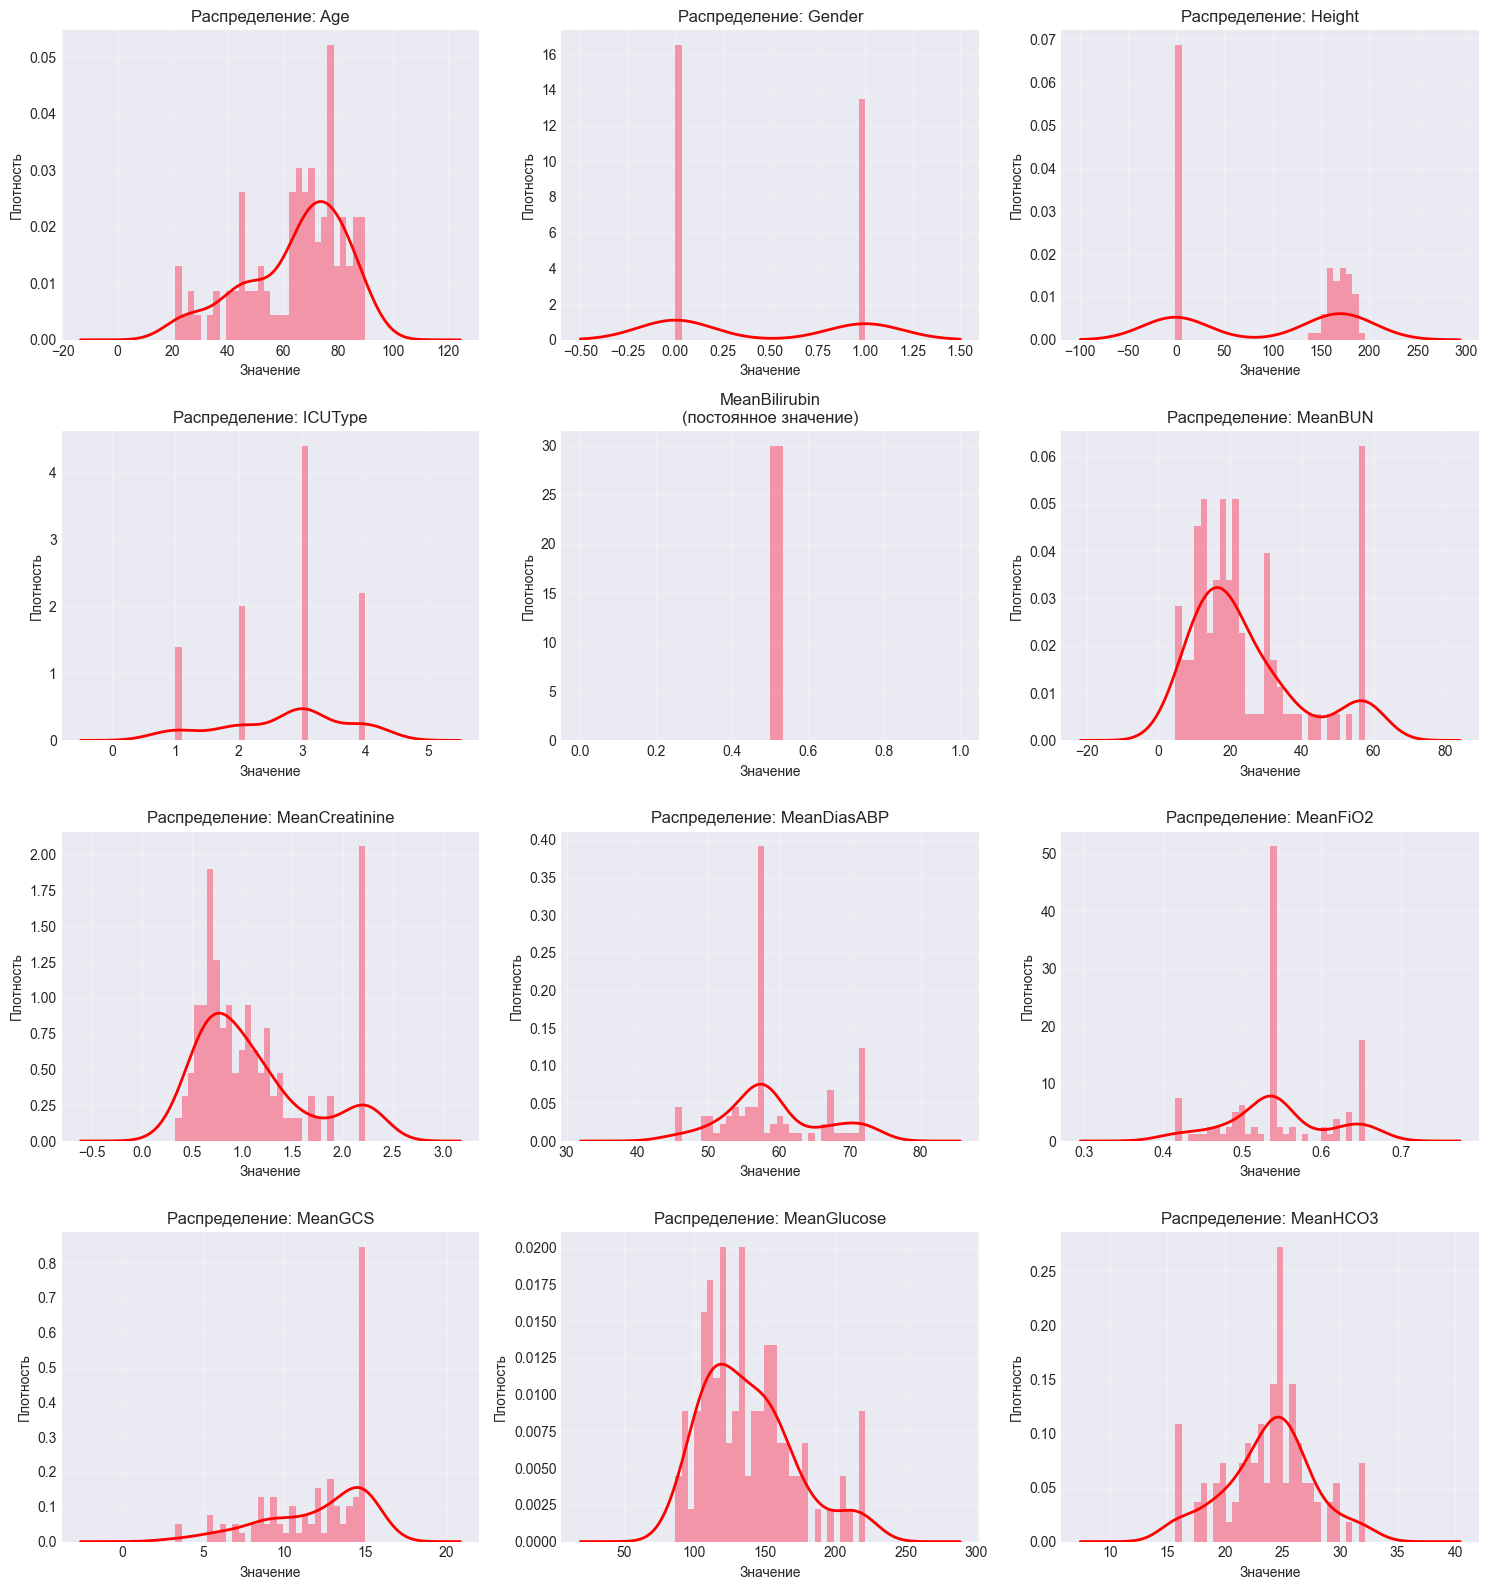

In [51]:
# 2. Графики распределения для всех признаков
print("\n2. ГРАФИКИ РАСПРЕДЕЛЕНИЯ:")

# Выбираем подмножество признаков для визуализации
plot_cols = numeric_cols[:12]  # Первые 12 числовых признаков

# Создаем сетку графиков
n_cols = 3
n_rows = (len(plot_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()
    
for i, col in enumerate(plot_cols):
    if i < len(axes):
        ax = axes[i]
        
        try:
            # Проверяем, достаточно ли уникальных значений для KDE
            unique_values = df_final[col].nunique()
            std_dev = df_final[col].std()
            
            # Гистограмма
            df_final[col].hist(bins=30, alpha=0.7, density=True, ax=ax)
            
            # Пытаемся построить KDE только если есть достаточная вариативность
            if unique_values > 1 and std_dev > 0.001:
                try:
                    df_final[col].plot(kind='kde', ax=ax, color='red', linewidth=2)
                except:
                    # Если KDE не работает, просто показываем гистограмму
                    pass
            
            ax.set_title(f'Распределение: {col}')
            ax.set_xlabel('Значение')
            ax.set_ylabel('Плотность')
            ax.grid(True, alpha=0.3)
            
            # Добавляем информацию о данных в заголовок
            if unique_values <= 1:
                ax.set_title(f'{col}\n(постоянное значение)')
            elif std_dev <= 0.001:
                ax.set_title(f'{col}\n(очень низкая дисперсия)')
                
        except Exception as e:
            # Если возникла ошибка, показываем простую гистограмму
            ax.clear()
            df_final[col].hist(bins=30, alpha=0.7, ax=ax)
            ax.set_title(f'{col}\n(ошибка KDE)')
            ax.set_xlabel('Значение')
            ax.set_ylabel('Частота')
            ax.grid(True, alpha=0.3)

# Скрываем пустые subplots
for i in range(len(plot_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [15]:
# 3. Анализ характера распределения
print("\n3. АНАЛИЗ ХАРАКТЕРА РАСПРЕДЕЛЕНИЯ:")

# Проверка нормальности для ключевых признаков
key_features = ['Age', 'Height', 'MeanHR', 'MeanTemp', 'MeanWeight']
key_features = [col for col in key_features if col in df_final.columns]

print("Проверка нормальности распределения (тест Шапиро-Уилка):")
for col in key_features:
    if len(df_final[col].dropna()) > 3:
        stat, p_value = stats.shapiro(df_final[col].dropna())
        is_normal = p_value > 0.05
        dist_type = "нормальное" if is_normal else "ненормальное"
        print(f"  {col:20s}: p-value = {p_value:.4f} ({dist_type})")


3. АНАЛИЗ ХАРАКТЕРА РАСПРЕДЕЛЕНИЯ:
Проверка нормальности распределения (тест Шапиро-Уилка):
  Age                 : p-value = 0.0000 (ненормальное)
  Height              : p-value = 0.0000 (ненормальное)
  MeanHR              : p-value = 0.1792 (нормальное)
  MeanTemp            : p-value = 0.3467 (нормальное)
  MeanWeight          : p-value = 0.0000 (ненормальное)



4. АНАЛИЗ ЗАВИСИМОСТЕЙ МЕЖДУ ПРИЗНАКАМИ:


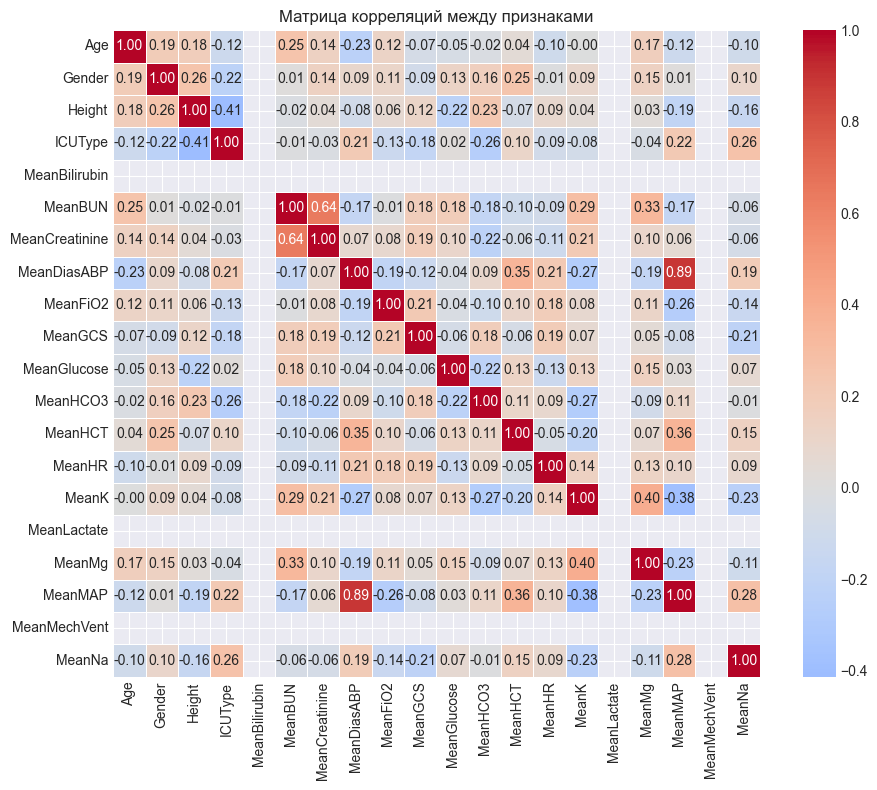

Найдены сильные корреляции (>0.7):
  MeanDiasABP ↔ MeanMAP: 0.890


In [29]:
# 4. Анализ зависимостей между признаками
print("\n4. АНАЛИЗ ЗАВИСИМОСТЕЙ МЕЖДУ ПРИЗНАКАМИ:")

# Матрица корреляций
# exclude = ["MeanAST", "MeanALT", "MeanALP", "MeanAlbumin"]
# numeric_cols = [c for c in numeric_cols if c not in exclude]

corr_matrix = df_final[numeric_cols[:20]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Матрица корреляций между признаками')
plt.tight_layout()
plt.show()

# Сильные корреляции
strong_correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = abs(corr_matrix.iloc[i, j])
        if corr_value > 0.7:
            strong_correlations.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if strong_correlations:
    print("Найдены сильные корреляции (>0.7):")
    for feat1, feat2, corr in strong_correlations[:5]:
        print(f"  {feat1} ↔ {feat2}: {corr:.3f}")
else:
    print("Сильных корреляций (>0.7) не обнаружено")


In [40]:
strong_corr = corr_matrix[(corr_matrix.abs() > 0.7) & (corr_matrix.abs() < 1.0)].stack().reset_index()
strong_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']
print("Сильные корреляции (>0.7 или <-0.7):")
print(strong_corr)

Сильные корреляции (>0.7 или <-0.7):
    Variable 1   Variable 2  Correlation
0  MeanDiasABP      MeanMAP     0.890031
1      MeanMAP  MeanDiasABP     0.890031



5. ВИЗУАЛИЗАЦИЯ ЗАВИСИМОСТЕЙ:


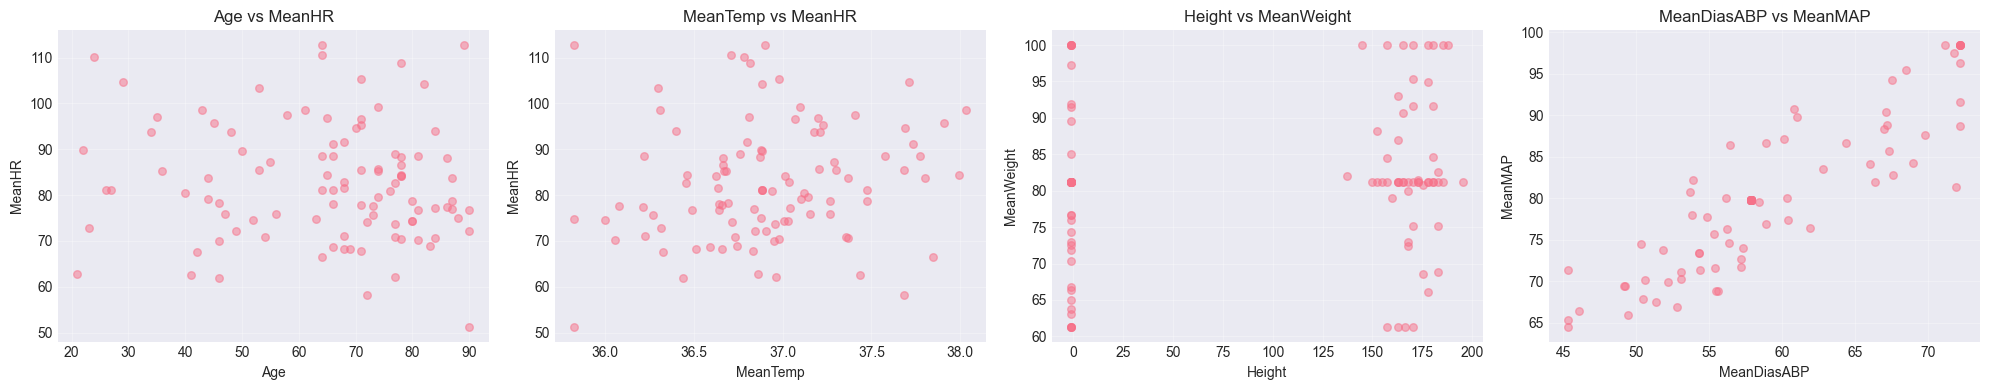

In [30]:
# 5. Scatter plot для визуализации зависимостей
print("\n5. ВИЗУАЛИЗАЦИЯ ЗАВИСИМОСТЕЙ:")

# Выбираем пары признаков для scatter plot
pairs = [('Age', 'MeanHR'), ('MeanTemp', 'MeanHR'), ('Height', 'MeanWeight'),  ('MeanDiasABP', 'MeanMAP')]
pairs = [(x, y) for x, y in pairs if x in df_final.columns and y in df_final.columns]

if pairs:
    fig, axes = plt.subplots(1, len(pairs), figsize=(5*len(pairs), 4))
    if len(pairs) == 1:
        axes = [axes]
    
    for idx, (x_col, y_col) in enumerate(pairs):
        axes[idx].scatter(df_final[x_col], df_final[y_col], alpha=0.5, s=30)
        axes[idx].set_xlabel(x_col)
        axes[idx].set_ylabel(y_col)
        axes[idx].set_title(f'{x_col} vs {y_col}')
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [31]:
df_final.head()

,RecordID,Age,Gender,Height,ICUType,MeanAlbumin,MeanALP,MeanALT,MeanAST,MeanBilirubin,MeanBUN,MeanCreatinine,MeanDiasABP,MeanFiO2,MeanGCS,MeanGlucose,MeanHCO3,MeanHCT,MeanHR,MeanK,MeanLactate,MeanMg,MeanMAP,MeanMechVent,MeanNa,MeanNIDiasABP,MeanNIMAP,MeanNISysABP,MeanPaCO2,MeanPaO2,MeanpH,MeanPlatelets,MeanRespRate,MeanSaO2,MeanSysABP,MeanTemp,MeanUrine,MeanWBC,MeanWeight
0,132539,54,0,-1.0,4,2.9,72.0,23.0,39.5,0.5,10.500000,0.750000,57.865079,0.538462,14.923077,160.000000,27.000000,32.500000,70.810811,4.20,1.8,1.700000,79.766993,1.0,136.500000,50.147059,71.559118,114.382353,38.055556,131.866667,7.398333,203.000000,19.166667,97.333333,115.661111,37.357143,171.052632,10.300000,81.134694
1,132540,76,1,175.3,2,2.9,72.0,23.0,39.5,0.5,18.333333,1.100000,58.897059,0.560000,13.333333,125.500000,22.333333,28.655556,80.794118,3.90,1.8,2.300000,76.940299,1.0,137.000000,56.714286,75.308571,112.500000,38.857143,206.035937,7.395000,178.600000,19.166667,97.333333,113.411765,36.939130,151.560976,11.266667,80.812121
2,132541,44,0,-1.0,3,2.9,72.0,23.0,39.5,0.5,4.666667,0.333333,67.125000,0.500000,5.923077,134.333333,25.000000,28.460000,83.759259,4.26,1.8,1.720000,90.437500,1.0,138.333333,79.000000,96.751316,132.263158,35.500000,134.500000,7.491691,89.666667,19.166667,97.333333,125.687500,37.800000,124.951219,4.700000,61.230769
3,132543,68,1,180.3,3,2.9,72.0,23.0,39.5,0.5,17.666667,0.766667,57.865079,0.538462,14.944444,117.333333,27.666667,37.442857,70.983333,4.00,1.8,2.033333,79.766993,1.0,139.333333,65.051724,83.885517,121.551724,38.055556,131.866667,7.398333,330.000000,19.166667,97.333333,115.661111,36.223077,285.123798,9.400000,84.600000
4,132545,88,0,-1.0,3,2.9,72.0,23.0,39.5,0.5,35.000000,1.000000,57.865079,0.538462,15.000000,102.500000,19.000000,29.550000,74.958333,4.32,1.8,1.550000,79.766993,1.0,139.500000,45.720930,74.946512,133.395349,38.055556,131.866667,7.398333,103.000000,19.166667,97.333333,115.661111,36.880000,62.131579,4.300000,81.134694


In [32]:
stats_df.head()

,count,mean,std,min,25%,50%,75%,max
Age,100.0,64.71,1.798557e+01,21.0,52.75,68.50,78.0,90.0
Gender,100.0,0.45,5.000000e-01,0.0,0.00,0.00,1.0,1.0
Height,100.0,92.76,8.565992e+01,-1.0,-1.00,153.65,170.2,195.6
ICUType,100.0,2.74,9.600084e-01,1.0,2.00,3.00,3.0,4.0
MeanAlbumin,100.0,2.90,1.785306e-15,2.9,2.90,2.90,2.9,2.9


In [12]:
# Сохранение
df_final.to_csv('patients_summary_final.csv', index=False, float_format='%.10g')

#### 2.5. Подготовка отчета
Подготовьте отчет, содержащий результаты, полученные в пп. 2.1-2.4. Загрузите для проверки отчет, а также исходный программный код.